In [1]:
%load_ext autoreload
%autoreload 2
#%pip install prettytable
import warnings
import json

warnings.filterwarnings("ignore")
# import the necessary package
from baseline.OE_GPLVM.aeb_gplvm import AEB_GPLVM, NNEncoder, kl_gaussian_loss_term
#from baseline.OE_GPLVM.composed_elbo import ComposedVariationalELBO
from baseline.OE_GPLVM.train import *
from baseline.OE_GPLVM.utils import *
from baseline.PyOD import PYOD
from gpytorch.mlls import KLGaussianAddedLossTerm
from gpytorch.distributions import MultivariateNormal
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import VariationalELBO, KLGaussianAddedLossTerm
from torch.distributions import kl_divergence
from gpytorch.priors import MultivariateNormalPrior
from tqdm import trange
from utils.data_generator import DataGenerator
from utils.myutils import Utils
import matplotlib.pyplot as plt
import numpy as np
import torch


2023-07-18 03:37:17.683609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 03:37:17.728746: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
plt.style.use("ggplot")
datagenerator = DataGenerator()  # data generator
utils = Utils()  # utils function

In [13]:
# dataset and model list / dict
dataset_list = [
    "01_ALOI",
    "02_annthyroid",
    "03_backdoor",
    "04_breastw",
    "05_campaign",
    "06_cardio",
    "07_Cardiotocography",
    "08_celeba",
    "09_census",
    "99_linear",
    "99_circles",
    "99_moons",
    "99_clusters",
    
]
dataset = dataset_list[-1]
datagenerator.dataset = dataset
data = datagenerator.generator(la=1.0, realistic_synthetic_mode=None, noise_type=None)
Y_train = torch.tensor(data["X_train"], dtype=torch.float32)
Y_test = torch.tensor(data["X_test"], dtype=torch.float32)
lb_train = torch.tensor(data["y_train"], dtype=torch.float32)
lb_test = torch.tensor(data["y_test"], dtype=torch.float32)

experiment = Experiment(
    dataset, 
    Y_train,
    Y_test,
    lb_train,
    lb_test,
    len(Y_train),
    Y_train.shape[1],
    100,
    2,
    50,
    1500,
    (5,5),
    0.005,
    "loe",
    "hard",
)
N = experiment.N
data_dim = experiment.data_dim
latent_dim = experiment.latent_dim
n_inducing = experiment.n_inducing
n_epochs = experiment.n_epochs
nn_layers = experiment.nn_layers
lr = experiment.lr
method = experiment.method
elbo_type = experiment.elbo
batch_size = experiment.batch_size

generating duplicate samples for dataset 99_clusters...
current noise type: None
{'Samples': 1000, 'Features': 2, 'Anomalies': 64, 'Anomalies Ratio(%)': 6.4}


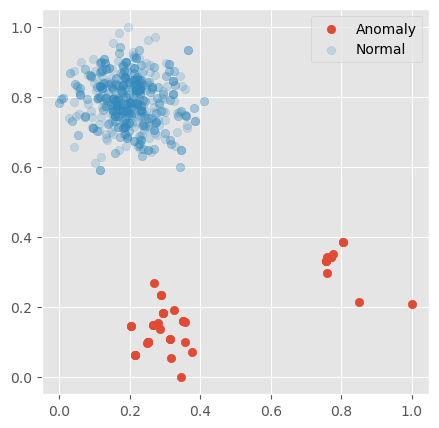

In [14]:
fig = plt.figure(figsize=(5, 5))
plt.subplot(111)
plt.scatter(
    data["X_train"][:, 0][np.where(lb_train == 1)[0]],
    data["X_train"][:, 1][np.where(lb_train == 1)[0]],
    label="Anomaly",
)
plt.scatter(
    data["X_train"][:, 0][np.where(lb_train == 0)[0]],
    data["X_train"][:, 1][np.where(lb_train == 0)[0]],
    label="Normal",
    alpha=0.2,
)
plt.legend()

Loss: -2132297856.0, iter no: : 100%|██████████| 1500/1500 [00:27<00:00, 55.14it/s]


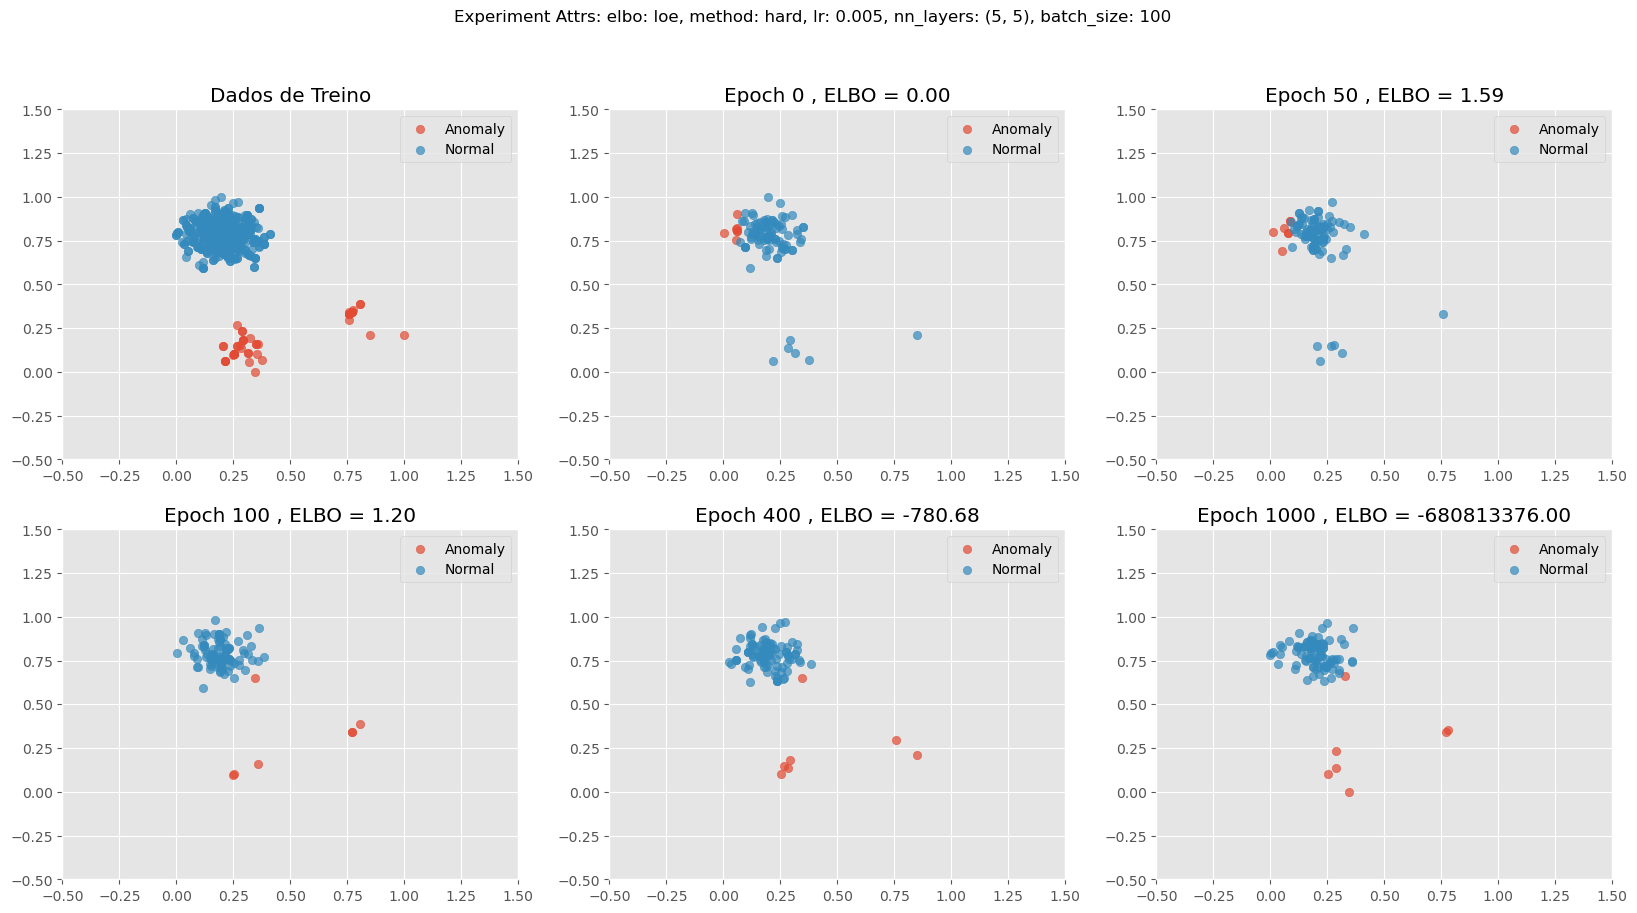

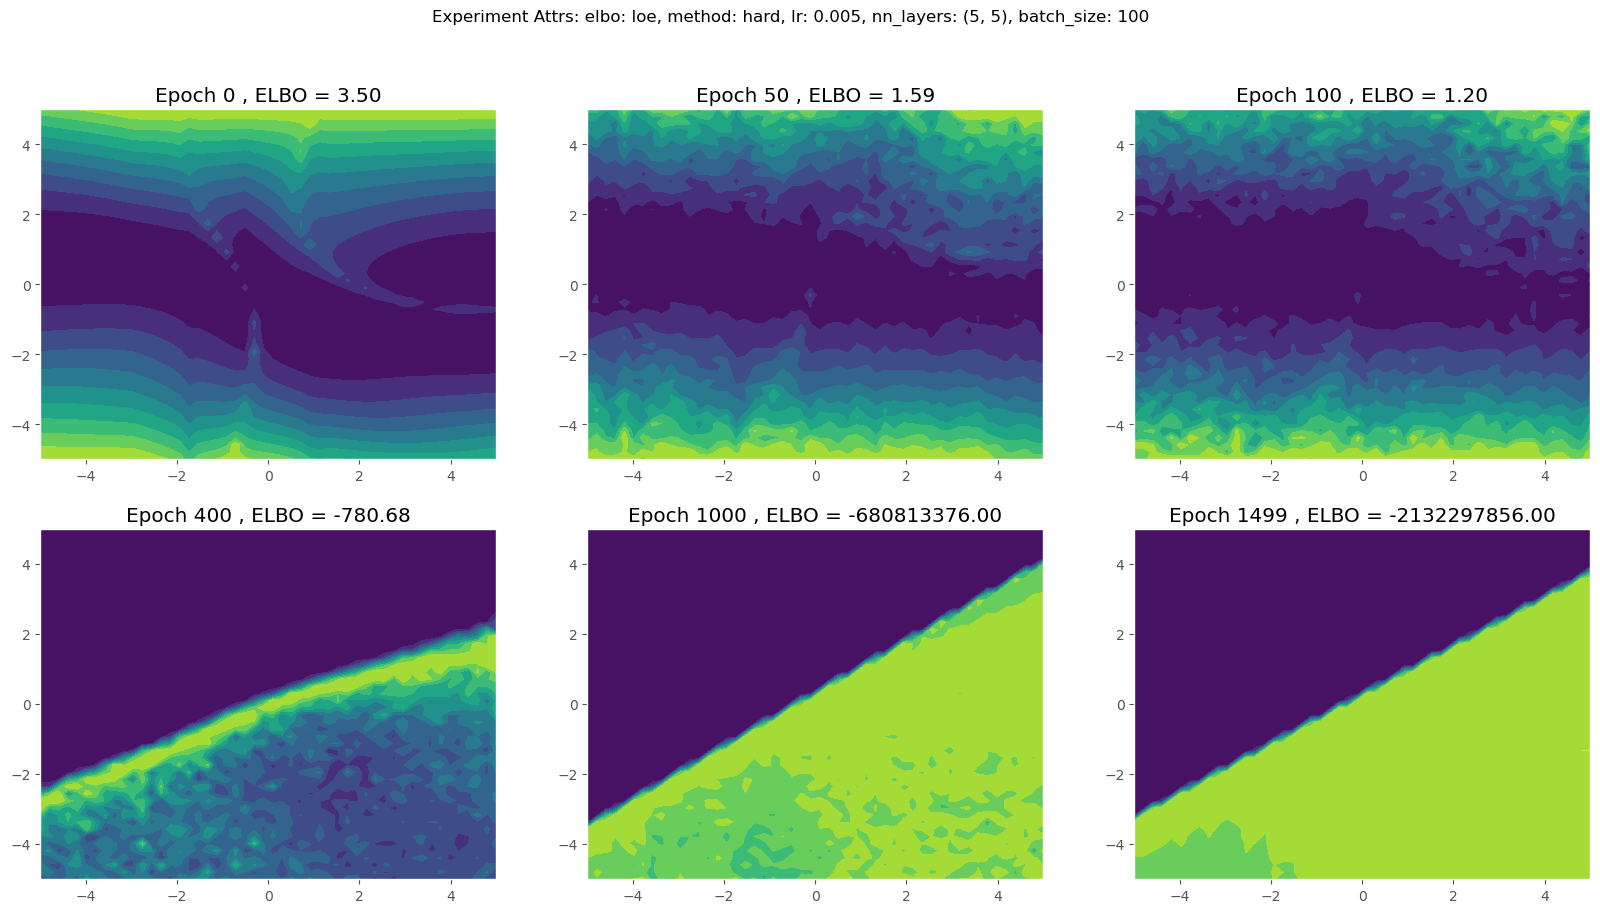

In [15]:
model_dict = {}
noise_trace_dict = {}
loss_list = []
noise_trace = []
report = Reporter(experiment)
lln_list = []
kln_list = []
lla_list = []
kla_list = []

X_prior_mean = torch.zeros(experiment.N, latent_dim)  # shape: N x Q
X_prior_covar = torch.eye(X_prior_mean.shape[1])
prior_x = MultivariateNormalPrior(X_prior_mean, X_prior_covar)
encoder = NNEncoder(experiment.N, latent_dim, prior_x, data_dim, nn_layers)
model = AEB_GPLVM(experiment.N, data_dim, latent_dim, n_inducing, encoder, nn_layers)
likelihood = GaussianLikelihood()
optimizer = torch.optim.Adam(
    [{"params": model.parameters()}, {"params": likelihood.parameters()}], lr
)
elbo = VariationalELBO(likelihood, model, num_data=len(Y_train), combine_terms=False)

model.train()
iterator = trange(n_epochs, leave=True)
for i in iterator:
    optimizer.zero_grad()
    idx_n, idx_a, batch_index, ratio = model._get_batch_indices(
        batch_size, lb_train, method=method
    )

    idx_n, idx_a = get_loe_idx(
        model, likelihood, Y_train, batch_index, train_data=experiment.N, ratio=ratio
    )
    
    target_n, target_a = Y_train[idx_n], Y_train[idx_a]
    
    ll_n, klu , kl_n = calculate_elbo(
        model,
        likelihood,
        target_n,
        num_data=experiment.N,
        batch_size=batch_size,
        elbo_shape=elbo_type,
    )
    ll_a, klu, kl_a = calculate_elbo(
        model,
        likelihood,
        target_a,
        num_data=experiment.N,
        batch_size=batch_size,
        elbo_shape=elbo_type,
    )
    loss_normal, loss_anomaly = (ll_n - kl_n).sum(), (ll_a - kl_a).sum()
    loss = -loss_loe(method, loss_normal, loss_anomaly).sum()

    loss_list.append(loss.item())
    noise_trace.append(np.round(likelihood.noise_covar.noise.item(), 3))
    if i in [0, 50, 100, 400, 1000, 1499]:
        if elbo_type == "loe":
            report.save_elbo_terms(ll_n.sum(), kl_n.sum(), ll_a.sum(), kl_a.sum())
        report.save_batch_info(i, idx_n, idx_a, loss.item())
        report.save_countour_evolution(model, likelihood)
        iterator.set_description(
            "Loss: " + str(float(np.round(loss.item(), 2))) + ", iter no: "
        )
    loss.backward()
    optimizer.step()
    # if loss < -10:
    #    break
model.store(loss_list, likelihood)
report.plot_train_evolution(save = True)
report.plot_countour_evolution(save = True)

In [16]:
with torch.no_grad():
    model.eval()
    likelihood.eval()
Y_pred_mean, Y_pred_covar = model.reconstruct_y(Y_test)
X_pred_mean, X_pred_covar = model.predict_latent(Y_test)

In [17]:
from sklearn.preprocessing import MinMaxScaler

lln, klu, kln = calculate_elbo(
    model,
    likelihood,
    Y_test,
    num_data=len(Y_test),
    batch_size=len(Y_test),
    elbo_shape=elbo_type,
)
score = -(lln - klu - kln).detach().numpy()


In [18]:
score = MinMaxScaler().fit_transform(np.reshape(score, (-1, 1)))
print(utils.metric(y_true=lb_test, y_score=score))

{'aucroc': 1.0, 'aucpr': 0.9999999999999998}
